## Librerias

In [1]:
import numpy as np
import pickle
import gdown
import os
import torch
from sklearn.model_selection import train_test_split
# from ipywidgets import IntProgress
# from IPython.display import display
import torch.nn as nn
from torch.utils.data import TensorDataset


## descarga del dataset

In [3]:
path = "D:/codigos/Autoencoder/ZTF/Dataset/recurrent_dataset-001.pk"
if not os.path.isfile(path):
    url = 'https://drive.google.com/drive/folders/1vqfoxF-KyMNnLxABZZ_kb76DrUrixEud'
    output="D:/codigos/Autoencoder/ZTF/Dataset"
    gdown.download_folder(url,output, quiet=False)
    # print(2)

In [26]:
path = "D:/codigos/Autoencoder/ZTF/Dataset/datosAutoencoder.npy"
if not os.path.isfile(path):
    with open('D:/codigos/Autoencoder/ZTF/Dataset/recurrent_dataset-001.pk', 'rb') as f:
        data = pickle.load(f)
    print(data.keys())

dict_keys(['template', 'science', 'difference', 'labels'])


## Exploración

In [4]:
print(np.shape(data["template"]))
print(np.shape(data["science"]))
print(np.shape(data["difference"]))
print(np.shape(data["labels"]))


(77146, 27, 27)
(77146, 3, 27, 27)
(77146, 3, 27, 27)
(77146,)


In [36]:
from collections import Counter
print(Counter(data["labels"]).keys())
print(Counter(data["labels"]).values())

dict_keys([2.0, 0.0, 1.0])
dict_values([49454, 26190, 1502])


## Creacion de los dataset

In [5]:
path = "./baseRecurrente.npy"
if not os.path.isfile(path):
    indices = np.arange(77146)
    (
        data_train,
        data_test_train,
        labels_train,
        labels_test_train,
        indices_train,
        indices_test_train,
    ) = train_test_split(data["template"], data["labels"], indices, test_size=0.1,stratify=data["labels"])

    indices = np.arange(len(indices_test_train))
    (
        data_test,
        data_val,
        labels_test,
        labels_val,
        indices_test,
        indices_val,
    ) = train_test_split(data["template"][indices_test_train], data["labels"][indices_test_train], indices, test_size=0.5,stratify=data["labels"][indices_test_train])

In [6]:
print(len(indices_val))
print(len(indices_test))
print(len(indices_train))

3858
3857
69431


## Recorte

In [9]:
path = "./baseRecurrente.npy"
if not os.path.isfile(path):
    train_label=data["labels"][indices_train]

    train_template=data["template"][indices_train,3:24,3:24]
    train_science=data["science"][indices_train,:,3:24,3:24]
    train_difference=data["difference"][indices_train,:,3:24,3:24]
    print("train")
    print(np.shape(train_template))
    print(np.shape(train_science))
    print(np.shape(train_difference))
    print("val")
    val_label=data["labels"][indices_test_train][indices_val]

    val_template=data["template"][indices_test_train,3:24,3:24][indices_val]
    val_science=data["science"][indices_test_train,:,3:24,3:24][indices_val]
    val_difference=data["difference"][indices_test_train,:,3:24,3:24][indices_val]
    print(np.shape(val_template))
    print(np.shape(val_science))
    print(np.shape(val_difference))
    print("test")
    test_label=data["labels"][indices_test_train][indices_test]

    test_template=data["template"][indices_test_train,3:24,3:24][indices_test]
    test_science=data["science"][indices_test_train,:,3:24,3:24][indices_test]
    test_difference=data["difference"][indices_test_train,:,3:24,3:24][indices_test]
    print(np.shape(test_template))
    print(np.shape(test_science))
    print(np.shape(test_difference))

train
(69431, 21, 21)
(69431, 3, 21, 21)
(69431, 3, 21, 21)
val
(3858, 21, 21)
(3858, 3, 21, 21)
(3858, 3, 21, 21)
test
(3857, 21, 21)
(3857, 3, 21, 21)
(3857, 3, 21, 21)


## Autoencoder

In [2]:
class AutoEncoderV5(nn.Module):
    def __init__(self,):
        super().__init__()
        self.encoder = nn.Sequential(

            # Bloque 1
            # [3x21x21]
            nn.ZeroPad2d(3),
            # [3x27x27]
            nn.Conv2d(3, 16, kernel_size=4, padding="same"),
            nn.ReLU(),
            # [16, 24, 24]
            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [32, 24, 24]
            nn.AvgPool2d(kernel_size=2),
            # [32, 12, 12]

            # Bloque 2
            nn.Conv2d(32, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [32, 12, 12]
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [64, 12, 12]
            nn.AvgPool2d(kernel_size=2),
            # [64, 6, 6]

            # Bloque 3
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [128, 6, 6]
            nn.AvgPool2d(kernel_size=2),
            # [128, 3, 3]

            # Bloque 4
            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.ReLU(),
            # [128, 3, 3]
            nn.AvgPool2d(kernel_size=2),
            # [128, 1, 1]   
        )
        self.decoder = nn.Sequential(
            # BLoque 1
            # [128, 1, 1]
            nn.ConvTranspose2d(128, 64, 2,stride=1),
            nn.ReLU(),
            # [64, 2, 2]

            # BLoque 2
            nn.ConvTranspose2d(64, 64, 3,stride=2),
            nn.ReLU(),
            # [64, 5, 5]
            nn.ConvTranspose2d(64, 32, 1,stride=1),
            nn.ReLU(),
            # [32, 5, 5]

            # Bloque 3
            nn.ConvTranspose2d(32, 32, 2,stride=2),
            nn.ReLU(),
            # [32, 10, 10]
            nn.ConvTranspose2d(32, 32, 1,stride=1),
            nn.ReLU(),
            # [32, 10, 10]

            # BLoque 4
            nn.ConvTranspose2d(32, 16, 3,stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 16, 1,stride=1),
            nn.ReLU(),
            # Bloque 5
            nn.ConvTranspose2d(16, 3, 1,stride=1),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.8),
            nn.Linear(128,64),
            nn.ReLU(),
            # Rotation concat
            # cyclic pooling
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,5),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
            encoder = self.encoder(x)
            decoder = self.decoder(encoder)
            classification = self.classifier(encoder)
            return decoder,classification

autoencoder = AutoEncoderV5() 
autoencoder.load_state_dict(torch.load('D:\codigos\Autoencoder\ZTF\Autoencoder\modelos entrenados\AutoencoderDefinitivo4.pth'))

<All keys matched successfully>

## Creacion tensordataset

In [11]:
path = "./basesRecurrente.npy"
if not os.path.isfile(path):
    largo_train=len(train_label)
    train=np.zeros([largo_train,3,3,21,21])
    print("train")
    for idx,data in enumerate(train):
        for i in range(3):
            data[i,0]=train_template[idx]
            data[i,1]=train_science[idx][i]
            data[i,2]=train_difference[idx][i]
    print(np.shape(train))
    print(np.shape(train_label))

    largo=len(train)
    dim=128

    data_train=np.zeros([largo,3,128])
  
    for idx, data in enumerate(train):
        medicion=torch.squeeze(autoencoder.encoder(torch.Tensor(data))).detach().numpy()
        data_train[idx]=medicion

train
(69431, 3, 3, 21, 21)
(69431,)


c:\Users\nicoi\MyEnv\inteligencia\lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,


In [13]:
path = "./basesRecurrente.npy"
if not os.path.isfile(path):
    largo_test=len(val_label)
    val=np.zeros([largo_test,3,3,21,21])
    print("val")
    for idx,data in enumerate(val):
        for i in range(3):
            data[i,0]=val_template[idx]
            data[i,1]=val_science[idx][i]
            data[i,2]=val_difference[idx][i]


    largo=len(val)
    data_val=np.zeros([largo,3,128])

    for idx, data in enumerate(val):
        medicion=torch.squeeze(autoencoder.encoder(torch.Tensor(data))).detach().numpy()
        data_val[idx]=medicion

val


In [17]:
path = "./basesRecurrente.npy"
if not os.path.isfile(path):
    largo_test=len(test_label)
    test=np.zeros([largo_test,3,3,21,21])
    print("Test")
    for idx,data in enumerate(test):
        for i in range(3):
            data[i,0]=test_template[idx]
            data[i,1]=test_science[idx][i]
            data[i,2]=test_difference[idx][i]


    largo=len(test)
    data_test=np.zeros([largo,3,128])

    for idx, data in enumerate(test):
        medicion=torch.squeeze(autoencoder.encoder(torch.Tensor(data))).detach().numpy()
        data_test[idx]=medicion

Test


In [18]:
print(np.shape(data_val))
print(np.shape(data_train))
print(np.shape(data_test))


(3858, 3, 128)
(69431, 3, 128)
(3857, 3, 128)


In [19]:
with open('baseRecurrente.npy', 'wb') as f:
    np.save(f, data_train)
    np.save(f, train_label)
    np.save(f, data_val)
    np.save(f, val_label)
    np.save(f, data_test)
    np.save(f, test_label)

In [3]:
with open('baseRecurrente.npy', 'rb') as f:
    data_train = np.load(f)
    train_label = np.load(f)
    data_val = np.load(f)
    val_label = np.load(f)
    data_test = np.load(f)
    test_label = np.load(f)

## Entrenamiento
### Para ver si funciona el codigo, el verdadero esta en el script de entrenamiento

In [22]:

my_datatrain = TensorDataset(torch.Tensor(data_train),torch.Tensor(train_label)) 
my_dataval = TensorDataset(torch.Tensor(data_val),torch.Tensor(val_label))

In [23]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,num_classes):
        super(RNN, self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size

        self.rnn=nn.GRU(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Sequential(nn.Linear(hidden_size,64),
                                nn.ReLU(),
                                nn.Linear(64,32),
                                nn.ReLU(),
                                nn.Linear(32,16),
                                nn.ReLU(),
                                nn.Linear(16,num_classes)
                            )

    
    def forward(self, x,gpu):
        if gpu== True:

            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).cuda()
        else:
            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size)

        out,_=self.rnn(x,h0)
        out=out[:,-1,:]
        out=self.fc(out)
        return out


In [24]:
input_size=128
hidden_size=200
num_classes=3
num_epoch=1
batch_size=32
lr=1e-3
num_layers=4
    

model=RNN(input_size,hidden_size,num_layers,num_classes)  
criterion= nn.CrossEntropyLoss() # Probar con Cross entropy
optimizer=torch.optim.Adam(model.parameters(),lr=lr) # Probar con Sgd



current_loss=0
all_losses=[]
batch_size=32
use_gpu=False

train_loader = torch.utils.data.DataLoader(my_datatrain, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
val_loader = torch.utils.data.DataLoader(my_dataval, batch_size=len(my_dataval), shuffle=False, pin_memory=use_gpu)
num_total_steps=len(train_loader)

if use_gpu:
    model.cuda()
    autoencoder.encoder.cuda()

for epoch in range(num_epoch):
    acumulado=0
    train_acc_count=0
    val_acc_count=0

    cumulative_train_corrects=0

    model.train()   
    for i, (x_batch, y_batch) in enumerate(train_loader):
        largo=len(x_batch)
        # print(np.shape(x_batch))
        if use_gpu:
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        outputs=model(x_batch,use_gpu)

        if use_gpu:
            y_batch = y_batch.type(torch.LongTensor).cuda()
        else:
            y_batch = y_batch.type(torch.LongTensor)

        class_prediction = torch.argmax(outputs, axis=1).long()
        train_acc_count += y_batch.shape[0]
        cumulative_train_corrects += (y_batch == class_prediction).sum().item()

        loss=criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acumulado+=loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epoch}], Loss:{acumulado/num_total_steps:.4f}, acc train: {cumulative_train_corrects / train_acc_count:.4f}")

    model.eval()
    with torch.no_grad():
        val_acc_count=0
        cumulative_val_corrects=0
        for x_val, y_val in val_loader:
            if use_gpu:
                x_val = x_val.cuda()
                y_val = y_val.cuda()

            y_predicted = model(x_val,use_gpu)
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            val_acc_count += y_val.shape[0]
            cumulative_val_corrects += (y_val == class_prediction).sum().item()

    print(f"Epoch [{epoch+1}/{num_epoch}], acc val: {cumulative_val_corrects / val_acc_count:.4f}")

Epoch [1/100], Loss:0.4178, acc train: 0.8274
Epoch [1/100], acc val: 0.8344
Epoch [2/100], Loss:0.3753, acc train: 0.8447
Epoch [2/100], acc val: 0.8561
Epoch [3/100], Loss:0.3593, acc train: 0.8550
Epoch [3/100], acc val: 0.8569
Epoch [4/100], Loss:0.3480, acc train: 0.8601
Epoch [4/100], acc val: 0.8626
Epoch [5/100], Loss:0.3404, acc train: 0.8647
Epoch [5/100], acc val: 0.8740
Epoch [6/100], Loss:0.3323, acc train: 0.8680
Epoch [6/100], acc val: 0.8678
Epoch [7/100], Loss:0.3286, acc train: 0.8692
Epoch [7/100], acc val: 0.8727
Epoch [8/100], Loss:0.3237, acc train: 0.8717
Epoch [8/100], acc val: 0.8751
Epoch [9/100], Loss:0.3208, acc train: 0.8730
Epoch [9/100], acc val: 0.8686
Epoch [10/100], Loss:0.3149, acc train: 0.8754
Epoch [10/100], acc val: 0.8688
Epoch [11/100], Loss:0.3116, acc train: 0.8764
Epoch [11/100], acc val: 0.8738
Epoch [12/100], Loss:0.3072, acc train: 0.8783
Epoch [12/100], acc val: 0.8743
Epoch [13/100], Loss:0.3032, acc train: 0.8791
Epoch [13/100], acc val

KeyboardInterrupt: 

## Resultados

In [6]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,num_classes):
        super(RNN, self).__init__()
        self.num_layers=num_layers
        self.hidden_size=hidden_size

        self.rnn=nn.GRU(input_size,hidden_size,num_layers,batch_first=True)
        self.fc=nn.Sequential(nn.Linear(hidden_size,64),
                                nn.Dropout(p=0.3),
                                nn.ReLU(),
                                nn.Linear(64,32),
                                nn.ReLU(),
                                nn.Linear(32,16),
                                nn.ReLU(),
                                nn.Linear(16,num_classes)
                            )

    
    def forward(self, x,gpu):
        if gpu== True:

            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).cuda()
        else:
            h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size)

        out,_=self.rnn(x,h0)
        out=out[:,-1,:]
        out=self.fc(out)
        return out

In [8]:
input_size=128
hidden_size=32
num_classes=3
num_layers=2
    

model=RNN(input_size,hidden_size,num_layers,num_classes)  
# model = torch.load("D:\codigos\Autoencoder\ZTF\Autoencoder\modelos entrenados\AutoencoderClasificador10.pth")
# model
model.load_state_dict(torch.load('D:\codigos\Autoencoder\ZTF\Recurrente\Modelos\RecurrenteFinal.pth'))

<All keys matched successfully>

In [9]:
with open('D:\codigos\Autoencoder\ZTF\Recurrente/baseRecurrente.npy', 'rb') as f:
    data_train = np.load(f)
    train_label = np.load(f)
    data_val = np.load(f)
    val_label = np.load(f)
    data_test = np.load(f)
    test_label = np.load(f)

### Matriz sin balancear

In [10]:
datatest_tensor = torch.Tensor(data_test)
# datatest_tensor = datatest_tensor.permute(0, 3, 1, 2)
my_datatest= TensorDataset(datatest_tensor,torch.Tensor(test_label))

In [11]:
test_loader = torch.utils.data.DataLoader(my_datatest, batch_size=len(my_datatest), shuffle=False, pin_memory=False)
model.eval()
with torch.no_grad():
    for x_test,y_test in test_loader:
        # print(np.shape(x_test))
        # print(np.shape(y_test))

        y_predicted = model(x_test,False)

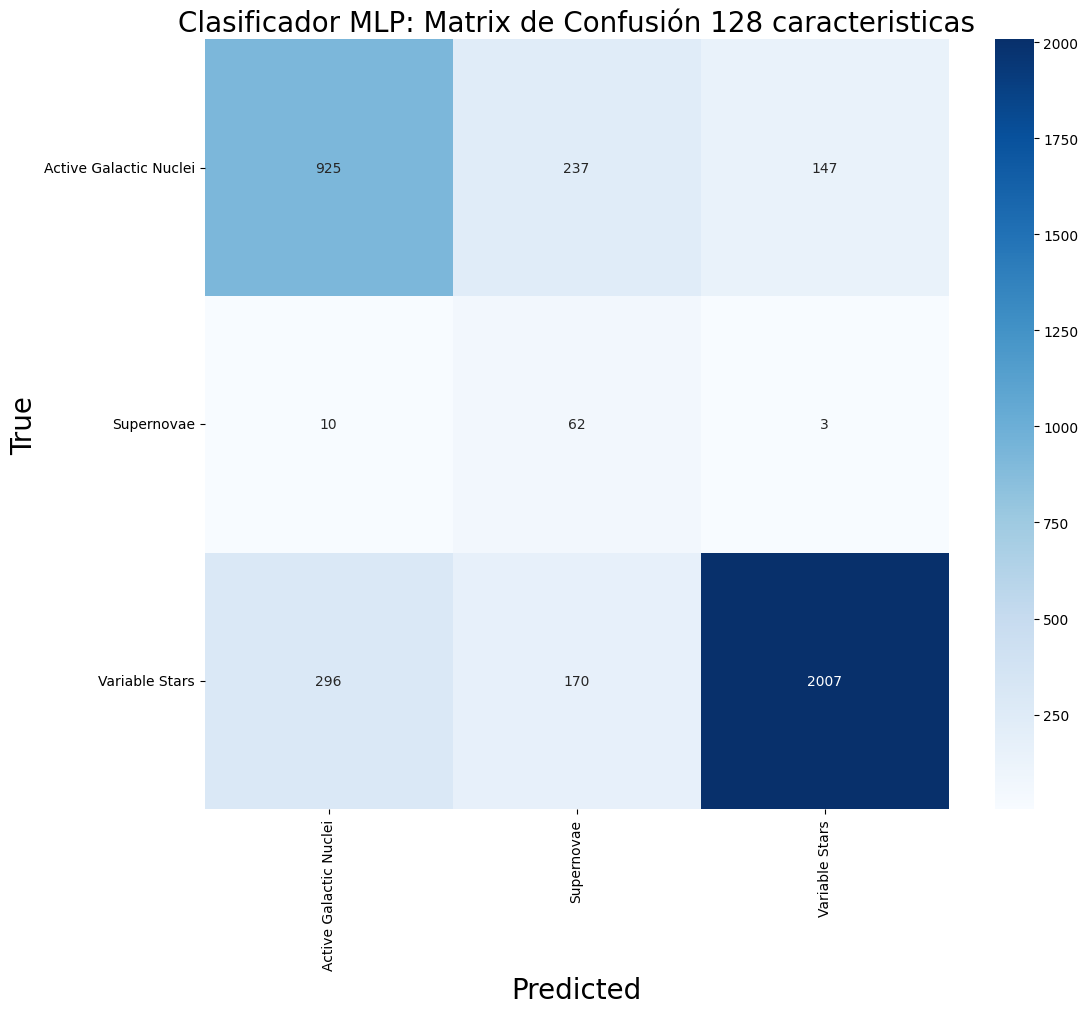

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# X_test=vector_test64
# predict=rbf_svc.predict(X_test)

class_prediction = torch.argmax(y_predicted, axis=1).long()
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python


# labels = le.classes_
class_names =  ["Active Galactic Nuclei","Supernovae","Variable Stars"]

cm = confusion_matrix(y_test, class_prediction)
# cmn = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(12, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True,cmap="Blues", ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Clasificador Recurrente: Matrix de Confusión 128 caracteristicas', fontsize=20)

# plt.savefig('ConMat24.png')
plt.show()

### Desbalance

In [27]:
from collections import Counter
print(Counter(data["labels"]).keys())
print(Counter(data["labels"]).values())


dict_keys([2.0, 0.0, 1.0])
dict_values([49454, 26190, 1502])


In [28]:
print(Counter(train_label).keys())
print(Counter(train_label).values())

dict_keys([2.0, 0.0, 1.0])
dict_values([44508, 23571, 1352])


In [30]:
print(Counter(test_label).keys())
print(Counter(test_label).values())

dict_keys([2.0, 0.0, 1.0])
dict_values([2473, 1309, 75])


## Balance

In [13]:
filtro2=(train_label==2)
filtro1=(train_label==1)
filtro0=(train_label==0)
label0=train_label[filtro0][:1352]
label1=train_label[filtro1][:1352]
label2=train_label[filtro2][:1352]

data0=data_train[filtro0][:1352]
data1=data_train[filtro1][:1352]
data2=data_train[filtro2][:1352]
data_train=np.concatenate((data0, data1,data2), axis=0)
train_label=np.concatenate((label0, label1,label2), axis=0)
print(np.shape(data_train))
print(np.shape(train_label))

(4056, 3, 128)
(4056,)


In [15]:
from collections import Counter
print(Counter(train_label).keys())
print(Counter(train_label).values())

dict_keys([0.0, 1.0, 2.0])
dict_values([1352, 1352, 1352])


In [16]:
filtro2=(val_label==2)
filtro1=(val_label==1)
filtro0=(val_label==0)
label0=val_label[filtro0][:75]
label1=val_label[filtro1][:75]
label2=val_label[filtro2][:75]

data0=data_val[filtro0][:75]
data1=data_val[filtro1][:75]
data2=data_val[filtro2][:75]
data_val=np.concatenate((data0, data1,data2), axis=0)
val_label=np.concatenate((label0, label1,label2), axis=0)
print(np.shape(data_val))
print(np.shape(val_label))

(225, 3, 128)
(225,)


In [17]:
print(Counter(val_label).keys())
print(Counter(val_label).values())

dict_keys([0.0, 1.0, 2.0])
dict_values([75, 75, 75])


In [18]:
filtro2=(test_label==2)
filtro1=(test_label==1)
filtro0=(test_label==0)

label0=test_label[filtro0][:75]
label1=test_label[filtro1][:75]
label2=test_label[filtro2][:75]

data0=data_test[filtro0][:75]
data1=data_test[filtro1][:75]
data2=data_test[filtro2][:75]
data_test=np.concatenate((data0, data1,data2), axis=0)
test_label=np.concatenate((label0, label1,label2), axis=0)

## Matriz balanceada

In [19]:

my_datatrain = TensorDataset(torch.Tensor(data_train),torch.Tensor(train_label)) 
my_dataval = TensorDataset(torch.Tensor(data_val),torch.Tensor(val_label))
my_datatest = TensorDataset(torch.Tensor(data_test),torch.Tensor(test_label))

In [20]:
test_loader = torch.utils.data.DataLoader(my_datatest, batch_size=len(my_datatest), shuffle=False, pin_memory=False)
model.eval()
with torch.no_grad():
    for x_test,y_test in test_loader:

        y_predicted = model(x_test,False)

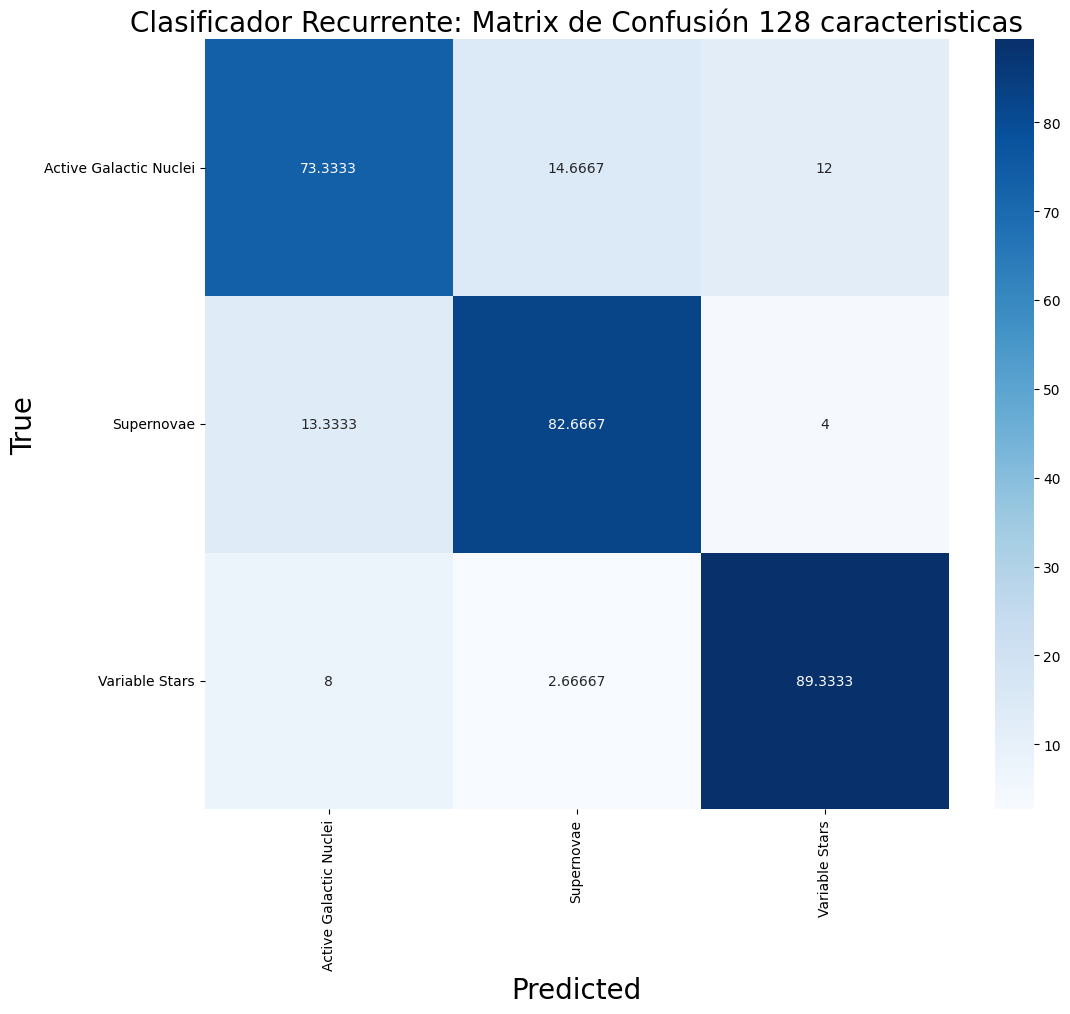

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# X_test=vector_test64
# predict=rbf_svc.predict(X_test)

class_prediction = torch.argmax(y_predicted, axis=1).long()
# https://stackoverflow.com/questions/65618137/confusion-matrix-for-multiple-classes-in-python


# labels = le.classes_
class_names =  ["Active Galactic Nuclei","Supernovae","Variable Stars"]

cm = confusion_matrix(y_test, class_prediction)
cmn = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(12, 10))
ax= plt.subplot()
sns.heatmap(cmn, annot=True,cmap="Blues", ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Clasificador Recurrente: Matrix de Confusión 128 caracteristicas', fontsize=20)

# plt.savefig('ConMat24.png')
plt.show()